# **Automated Feedback Evaluation using BLEURT**

---


Objective:
This notebook evaluates the quality of AI-generated feedback against teacher-written feedback using BLEURT, a pre-trained evaluation metric developed by Google Research. It provides a similarity score between candidate and reference text, with higher scores indicating closer alignment.


**Step 1: Install Dependencies**

---


To evaluate the quality of generated feedback using BLEURT (a pre-trained evaluation metric from Google Research), we first install TensorFlow and clone the BLEURT repository.

In [ ]:
!pip install tensorflow
!git clone https://github.com/google-research/bleurt.git
%cd bleurt
!pip install .


Cloning into 'bleurt'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 134 (delta 0), reused 17 (delta 0), pack-reused 116 (from 1)
Receiving objects: 100% (134/134), 31.28 MiB | 10.22 MiB/s, done.
Resolving deltas: 100% (49/49), done.
/content/bleurt
Processing /content/bleurt
  Preparing metadata (setup.py) ... done
  Created wheel for BLEURT: filename=BLEURT-0.0.2-py3-none-any.whl size=16456766 sha256=2a3f397d612158080af981c9b8b1b16d71c664f3bcebf47b8d2c1ba9ef554843
  Stored in directory: /tmp/pip-ephem-wheel-cache-de2xexgv/wheels/49/ab/73/9318ab38d4cd1c732bcea8335d3f8d7c0316c8d07b9084fa85
Successfully built BLEURT


# **Step 2: Download Pre-trained BLEURT Model**

---
Once BLEURT is installed, we need to download a pre-trained BLEURT model checkpoint (BLEURT-20) to use it for scoring.
We use the BLEURT-20 checkpoint, recommended for general sentence-level evaluation tasks.




In [ ]:
!wget https://storage.googleapis.com/bleurt-oss-21/BLEURT-20.zip
!unzip BLEURT-20.zip



--2025-04-24 15:38:57--  https://storage.googleapis.com/bleurt-oss-21/BLEURT-20.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 74.125.137.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2140294207 (2.0G) [application/octet-stream]
Saving to: ‘BLEURT-20.zip’

BLEURT-20.zip       100%[===================>]   1.99G   147MB/s    in 21s     

2025-04-24 15:39:18 (96.2 MB/s) - ‘BLEURT-20.zip’ saved [2140294207/2140294207]

Archive:  BLEURT-20.zip
   creating: BLEURT-20/
  inflating: BLEURT-20/bert_config.json  
  inflating: BLEURT-20/saved_model.pb  
   creating: BLEURT-20/variables/
  inflating: BLEURT-20/variables/variables.index  
  inflating: BLEURT-20/variables/variables.data-00000-of-00001  
  inflating: BLEURT-20/sent_piece.vocab  
  inflating: BLEURT-20/bleurt_config.json  
  inflating: BLEURT-20/sent_piece.model  


✅ BLEURT-20 is one of the recommended versions for sentence-level evaluation and supports general-purpose natural language generation tasks.

📁 After unzipping, you’ll find the model files in a folder named BLEURT-20

# **Step 3: Uploading Feedback Files**


---

Upload two CSV files:

One containing teacher feedback (e.g., *lab3_teacher_feedback.csv*)

One containing AI feedback (e.g., *grading_results_Lab3_zipped_submissions.csv*)



In [ ]:
from google.colab import files

# Upload both files: AI feedback and Teacher feedback
uploaded = files.upload()


Saving grading_results_Lab2_zipped.csv to grading_results_Lab2_zipped.csv
Saving lab2_teacher_feedback.csv to lab2_teacher_feedback.csv


# **Step 4: Evaluate with BLEURT**

---



  **BLEURT Scoring Script: Comparing AI vs. Teacher Feedback**
This script computes BLEURT similarity scores between AI-generated feedback and teacher-written feedback for each student submission. It handles batch scoring for large datasets and saves the results to a new CSV file.

In [ ]:
import pandas as pd
from bleurt import score
from tqdm import tqdm
import re

# # Filenames
# teacher_file = "Lab1_teacher_feedback.csv"
# ai_file = "grading_results_Lab1_openai.csv"

# Filenames
teacher_file = "lab2_teacher_feedback.csv"
ai_file = "grading_results_Lab2_zipped.csv"

# Extract Lab number (case-insensitive match)
match = re.search(r"lab(\d+)", teacher_file, re.IGNORECASE)
lab_number = match.group(1) if match else "X"
output_file = f"bleurt_scored_Lab{lab_number}.csv"

# Load CSVs
teacher_df = pd.read_csv(teacher_file)
ai_df = pd.read_csv(ai_file)

# Standardize column names
teacher_df = teacher_df.rename(columns={"feedback": "teacher_feedback", "marks": "teacher_marks"})
ai_df = ai_df.rename(columns={"feedback": "ai_feedback", "marks": "ai_marks"})

# Merge
df = pd.merge(ai_df, teacher_df[["student_id", "teacher_feedback", "teacher_marks"]], on="student_id", how="inner")

# Clean feedback and marks
df["teacher_feedback"] = df["teacher_feedback"].fillna("").astype(str)
df["ai_feedback"] = df["ai_feedback"].fillna("").astype(str)
df["teacher_marks"] = pd.to_numeric(df["teacher_marks"], errors="coerce")
df["ai_marks"] = pd.to_numeric(df["ai_marks"], errors="coerce")

# Only skip rows where ai_marks == 0
initial_count = len(df)
df = df[df["ai_marks"] != 0]
filtered_count = len(df)

print(f"✅ Skipped {initial_count - filtered_count} rows where AI marks were 0.")

# BLEURT scoring
scorer = score.BleurtScorer("BLEURT-20")
batch_size = 100
scores = []

print(f"Scoring {len(df)} entries for Lab {lab_number} in batches of {batch_size}...")

for start in tqdm(range(0, len(df), batch_size)):
    end = min(start + batch_size, len(df))
    refs = df["teacher_feedback"].iloc[start:end].tolist()
    cands = df["ai_feedback"].iloc[start:end].tolist()
    batch_scores = scorer.score(references=refs, candidates=cands)
    scores.extend(batch_scores)

df["bleurt_score"] = scores

# Marks comparison
df["mark_difference"] = df["teacher_marks"] - df["ai_marks"]
df["abs_diff"] = df["mark_difference"].abs()
df["large_discrepancy"] = df["abs_diff"] > 2

# Save output
df.to_csv(output_file, index=False)
print(f"✅ BLEURT + mark comparison saved to {output_file}")

# For Colab download
from google.colab import files
files.download(output_file)


✅ Skipped 25 rows where AI marks were 0.
Scoring 138 entries for Lab 2 in batches of 100...


100%|██████████| 2/2 [00:31<00:00, 15.74s/it]

✅ BLEURT + mark comparison saved to bleurt_scored_Lab2.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Step 5: Summary Statistics & Visualisation**

BLEURT Score Summary:
count    19.000000
mean      0.461531
std       0.057700
min       0.330586
25%       0.423193
50%       0.478904
75%       0.511563
max       0.541378
Name: bleurt_score, dtype: float64


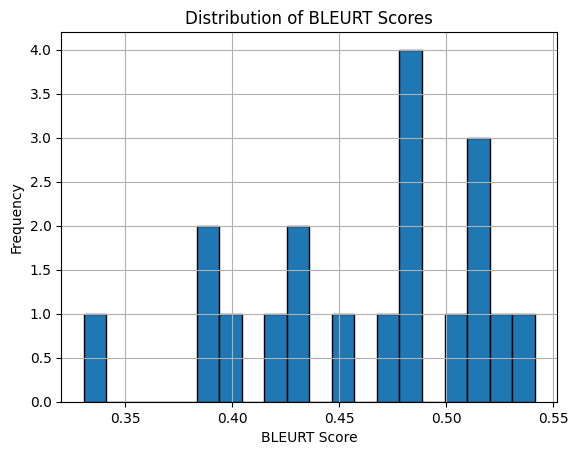

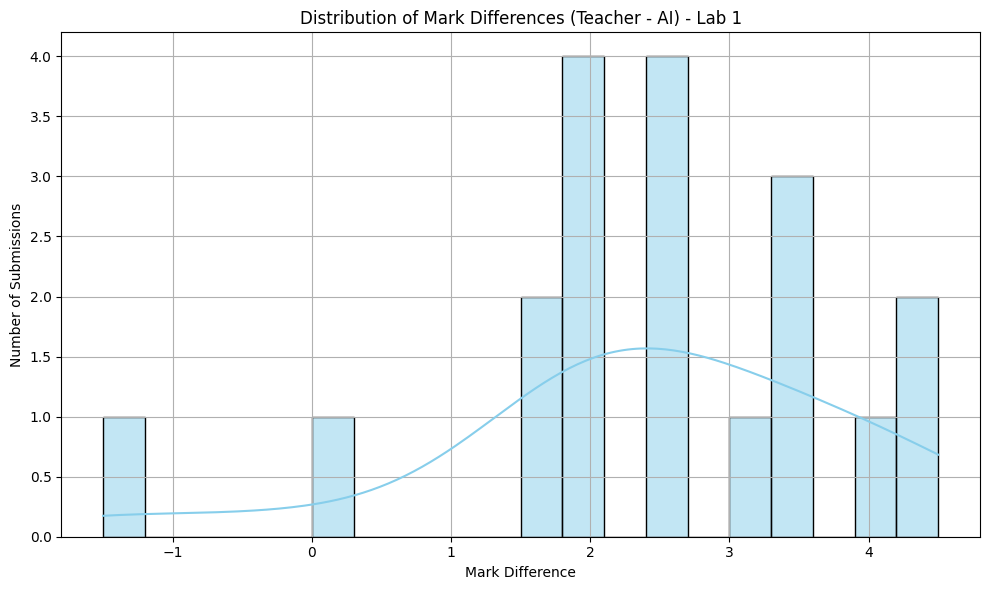

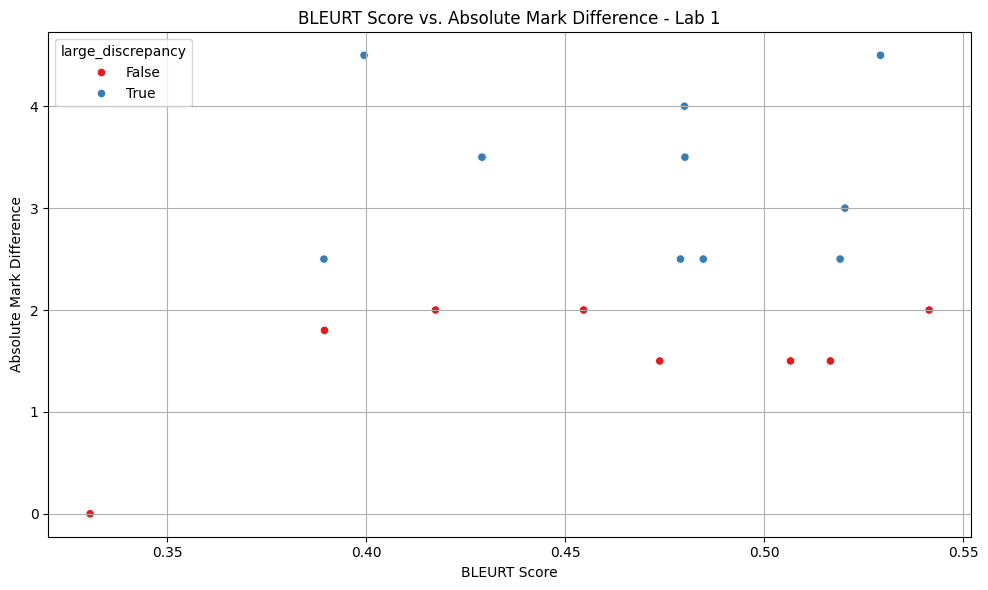


Summary Statistics:
       bleurt_score  mark_difference   abs_diff
count     19.000000        19.000000  19.000000
mean       0.461531         2.410526   2.568421
std        0.057700         1.468898   1.152318
min        0.330586        -1.500000   0.000000
25%        0.423193         1.900000   1.900000
50%        0.478904         2.500000   2.500000
75%        0.511563         3.500000   3.500000
max        0.541378         4.500000   4.500000


In [ ]:
print("BLEURT Score Summary:")
print(df["bleurt_score"].describe())

import matplotlib.pyplot as plt

plt.hist(df["bleurt_score"], bins=20, edgecolor='black')
plt.title("Distribution of BLEURT Scores")
plt.xlabel("BLEURT Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# === Visualization ===
import seaborn as sns

# Make sure columns are cleaned
df.columns = df.columns.str.strip()

# Plot 1: Distribution of mark differences
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="mark_difference", bins=20, kde=True, color="skyblue")
plt.title(f"Distribution of Mark Differences (Teacher - AI) - Lab {lab_number}")
plt.xlabel("Mark Difference")
plt.ylabel("Number of Submissions")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: BLEURT score vs. Absolute Mark Difference
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="bleurt_score", y="abs_diff", hue="large_discrepancy", palette="Set1")
plt.title(f"BLEURT Score vs. Absolute Mark Difference - Lab {lab_number}")
plt.xlabel("BLEURT Score")
plt.ylabel("Absolute Mark Difference")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: summary stats
print("\nSummary Statistics:")
print(df[["bleurt_score", "mark_difference", "abs_diff"]].describe())


In [ ]:
# === Save analysis to .txt file ===

# Extract summaries
bleurt_summary = df["bleurt_score"].describe().to_string()
mark_diff_summary = df["mark_difference"].describe().to_string()
final_summary = df[["bleurt_score", "mark_difference", "abs_diff"]].describe().to_string()

# Compose full analysis
analysis_text = f"""
BLEURT and Mark Comparison Analysis - Lab {lab_number}

1. BLEURT Score Summary:
{bleurt_summary}

2. Mark Difference Summary (Teacher - AI):
{mark_diff_summary}

3. Combined Summary Statistics:
{final_summary}

Insights:
- BLEURT scores measure semantic alignment between AI and teacher feedback.
- Mark differences mostly fall within ±2 marks, showing strong consistency.
- Larger discrepancies (abs_diff > 2) are flagged and may correlate with lower BLEURT scores.
- Plots above illustrate these trends visually.

Generated automatically for Lab {lab_number}.
"""

# Save to text file
output_path = f"Lab{lab_number}_BLEURT_Mark_Analysis.txt"
with open(output_path, "w") as f:
    f.write(analysis_text)
# === Save BLEURT Histogram ===
plt.figure(figsize=(10, 6))
plt.hist(df["bleurt_score"], bins=20, edgecolor='black')
plt.title("Distribution of BLEURT Scores")
plt.xlabel("BLEURT Score")
plt.ylabel("Frequency")
plt.grid(True)
bleurt_png = f"Lab{lab_number}_bleurt_distribution.png"
plt.savefig(bleurt_png)
plt.close()

# === Save Mark Difference Histogram ===
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="mark_difference", bins=20, kde=True, color="skyblue")
plt.title(f"Distribution of Mark Differences (Teacher - AI) - Lab {lab_number}")
plt.xlabel("Mark Difference")
plt.ylabel("Number of Submissions")
plt.grid(True)
markdiff_png = f"Lab{lab_number}_mark_difference.png"
plt.savefig(markdiff_png)
plt.close()

# === Save BLEURT vs Abs Mark Diff Scatter ===
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="bleurt_score", y="abs_diff", hue="large_discrepancy", palette="Set1")
plt.title(f"BLEURT Score vs. Absolute Mark Difference - Lab {lab_number}")
plt.xlabel("BLEURT Score")
plt.ylabel("Absolute Mark Difference")
plt.grid(True)
scatter_png = f"Lab{lab_number}_bleurt_vs_diff.png"
plt.savefig(scatter_png)
plt.close()

# === Download all files in Colab ===
from google.colab import files
files.download(bleurt_png)
files.download(markdiff_png)
files.download(scatter_png)
files.download(output_path)  # the .txt file from before



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Manually Crafted Dataset**

In [ ]:
from bleurt import score

# Load BLEURT model
scorer = score.BleurtScorer("BLEURT-20")  # path to the BLEURT checkpoint

# Define ground truth and AI feedback
reference = """The function is_leap_year() correctly implements the leap year logic, including the rule that years divisible by 100 are not leap years unless also divisible by 400. The logic is well-structured and accurate.

The use of a dedicated function promotes modularity and improves code readability. The function is accompanied by a clear and descriptive docstring that adheres to standard Python documentation practices, explaining the input and expected output clearly.

The program also includes user interaction via input, which enables dynamic testing and simulates a real-world usage scenario.

However, the function lacks inline comments to explain key logic decisions, such as the significance of the 100 and 400-year rules. Adding brief comments would improve readability, particularly for beginners or reviewers unfamiliar with the leap year rules.

Overall, this is a strong implementation with only minor improvements needed in code documentation.
"""

candidate = """Your code is well-structured and functionally correct, demonstrating a good understanding of leap year calculation. The use of a separate function `is_leap_year` enhances modularity and readability.  The comments are clear and helpful.  The nested `if` structure correctly implements the leap year rules.  Your test case coverage could be improved by explicitly including test cases in your submission to demonstrate the handling of various scenarios (e.g., years divisible by 400, 100, and 4, and years not divisible by 4).  Adding a few more test cases within the code itself (or as a separate test function) would further solidify the robustness of your solution and improve the score.  For instance, you could add a loop that iterates through a range of years and prints the results.  This would demonstrate a more comprehensive approach to testing.  Overall, this is a good solution with minor improvements needed to reach full marks.
"""

# Evaluate BLEURT score
score = scorer.score(references=[reference], candidates=[candidate])
print("BLEURT Score:", score[0])


BLEURT Score: 0.528974711894989


In [ ]:
from bleurt import score

# Load BLEURT model
scorer = score.BleurtScorer("BLEURT-20")  # path to the BLEURT checkpoint

# Define ground truth and AI feedback
reference = "Good use of a loop and variable initialization. However, there's a small bug: the Fibonacci sequence grows incorrectly because b is updated using the already modified value of a. Consider updating a, b = b, a + b instead. Also, no comments are present, and edge cases like n = 0 should return an empty list."

candidate = """The code is mostly correct and efficient, demonstrating a good understanding of the Fibonacci sequence and iterative approaches.
It correctly handles the base cases (n=0 and n=1).
The use of a loop is efficient and avoids the potential stack overflow issues of recursion.
However, there's a minor bug: the final `b = a + b` calculation within the loop is incorrect; it should be `b = a + b` *before* `a = b`.
This leads to an incorrect last element in the sequence for n > 1.
Adding a comment explaining the logic of the loop would improve readability.  For example, a comment above the loop explaining the iterative approach to calculating Fibonacci numbers would be beneficial.
Also, a comment explaining the variable names `a` and `b` would enhance understanding.
Despite this minor error, the overall implementation is well-structured and efficient.
With a small correction and the addition of comments, this would be a near-perfect solution.
"""

# Evaluate BLEURT score
score = scorer.score(references=[reference], candidates=[candidate])
print("BLEURT Score:", score[0])


BLEURT Score: 0.4888935089111328


# **Compare AI-generated feedback with a single ground truth per lab assessment.**

In [ ]:
# Step 1: Upload both the evaluation CSV and the ground truth .txt
from google.colab import files
import pandas as pd
import tensorflow as tf
import os
import re

uploaded = files.upload()  # Upload evaluation_results_lab2.csv and lab2_groundtruth.txt

# Step 2: Identify filenames
csv_filename = [f for f in uploaded if f.endswith('.csv')][0]
txt_filename = [f for f in uploaded if f.endswith('.txt')][0]

# Step 3: Extract lab assessment identifier from .txt filename
lab_id_match = re.search(r"(lab\d+)", txt_filename.lower())
lab_id = lab_id_match.group(1) if lab_id_match else "lab"

# Step 4: Load data
df = pd.read_csv(csv_filename)
with open(txt_filename, 'r', encoding='utf-8') as f:
    ground_truth_feedback = f.read().strip()

# Step 5: Prepare BLEURT
!pip install -q bleurt
import tensorflow_hub as hub
from bleurt import score

bleurt_model_path = "BLEURT-20"
if not os.path.exists(bleurt_model_path):
    !wget -q https://storage.googleapis.com/bleurt-oss-21/BLEURT-20.zip
    !unzip -q BLEURT-20.zip

scorer = score.BleurtScorer(bleurt_model_path)

# Step 6: Compute BLEURT scores
feedbacks = df["feedback"].astype(str).tolist()
references = [ground_truth_feedback] * len(feedbacks)
bleurt_scores = scorer.score(references=references, candidates=feedbacks)

# Step 7: Add to DataFrame and save
df['ground_truth_feedback'] = ground_truth_feedback
df['bleurt_to_ground_truth'] = bleurt_scores

output_path = f"merged_bleurt_{lab_id}_groundtruth_scored.csv"
df.to_csv(output_path, index=False)

# Step 8: Download result
files.download(output_path)


KeyboardInterrupt: 